In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:

# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:

# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,Trump names Dow Chemical CEO Liveris to head M...,(Reuters) - President-elect Donald Trump said ...,politicsNews,"December 10, 2016",true
1,U.S. airlines scramble to evacuate residents a...,(Reuters) - Airlines were racing against the c...,worldnews,"September 7, 2017",true
2,Special Counsel Mueller produces evidence that...,WASHINGTON (Reuters) - U.S. Special Counsel Ro...,politicsNews,"December 8, 2017",true
3,Ivanka Trump Legally BARRED From Participatin...,The Office of Government Ethics has said that ...,News,"May 1, 2017",fake
4,Twitter FRIES Trump ALIVE Over This Tweet Abo...,"On Thursday, the U.K. voted to leave the Europ...",News,"June 24, 2016",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Trump names Dow Chemical CEO Liveris to head M...,(Reuters) - President-elect Donald Trump said ...,politicsNews,true
1,U.S. airlines scramble to evacuate residents a...,(Reuters) - Airlines were racing against the c...,worldnews,true
2,Special Counsel Mueller produces evidence that...,WASHINGTON (Reuters) - U.S. Special Counsel Ro...,politicsNews,true
3,Ivanka Trump Legally BARRED From Participatin...,The Office of Government Ethics has said that ...,News,fake
4,Twitter FRIES Trump ALIVE Over This Tweet Abo...,"On Thursday, the U.K. voted to leave the Europ...",News,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,(Reuters) - President-elect Donald Trump said ...,politicsNews,true
1,(Reuters) - Airlines were racing against the c...,worldnews,true
2,WASHINGTON (Reuters) - U.S. Special Counsel Ro...,politicsNews,true
3,The Office of Government Ethics has said that ...,News,fake
4,"On Thursday, the U.K. voted to leave the Europ...",News,fake


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,(reuters) - president-elect donald trump said ...,politicsNews,true
1,(reuters) - airlines were racing against the c...,worldnews,true
2,washington (reuters) - u.s. special counsel ro...,politicsNews,true
3,the office of government ethics has said that ...,News,fake
4,"on thursday, the u.k. voted to leave the europ...",News,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,reuters presidentelect donald trump said on f...,politicsNews,true
1,reuters airlines were racing against the cloc...,worldnews,true
2,washington reuters us special counsel robert ...,politicsNews,true
3,the office of government ethics has said that ...,News,fake
4,on thursday the uk voted to leave the european...,News,fake


In [14]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patab\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [15]:
data.head()

,text,subject,target
0,reuters presidentelect donald trump said frida...,politicsNews,true
1,reuters airlines racing clock clear many custo...,worldnews,true
2,washington reuters us special counsel robert m...,politicsNews,true
3,office government ethics said ivanka trump mus...,News,fake
4,thursday uk voted leave european union course ...,News,fake



Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


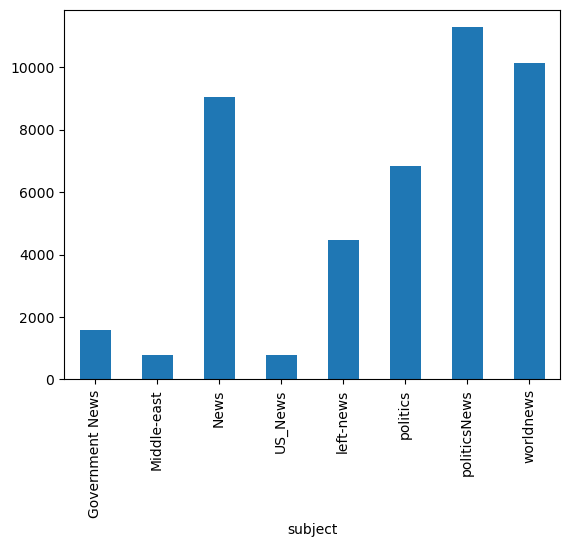

In [16]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


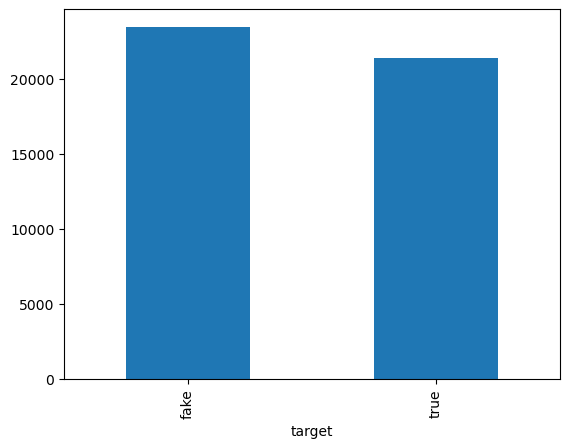

In [17]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

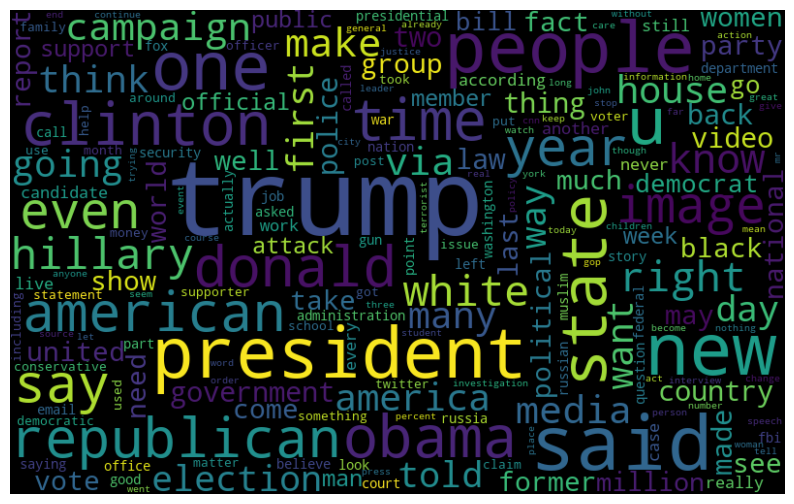

In [20]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

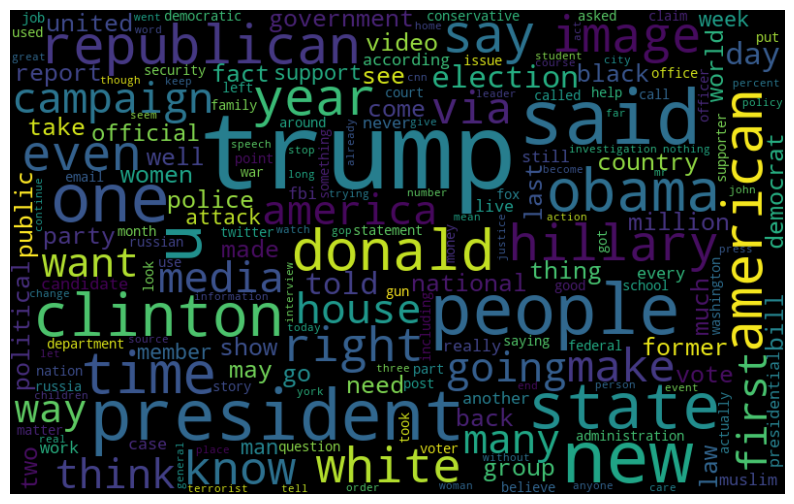

In [21]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [23]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

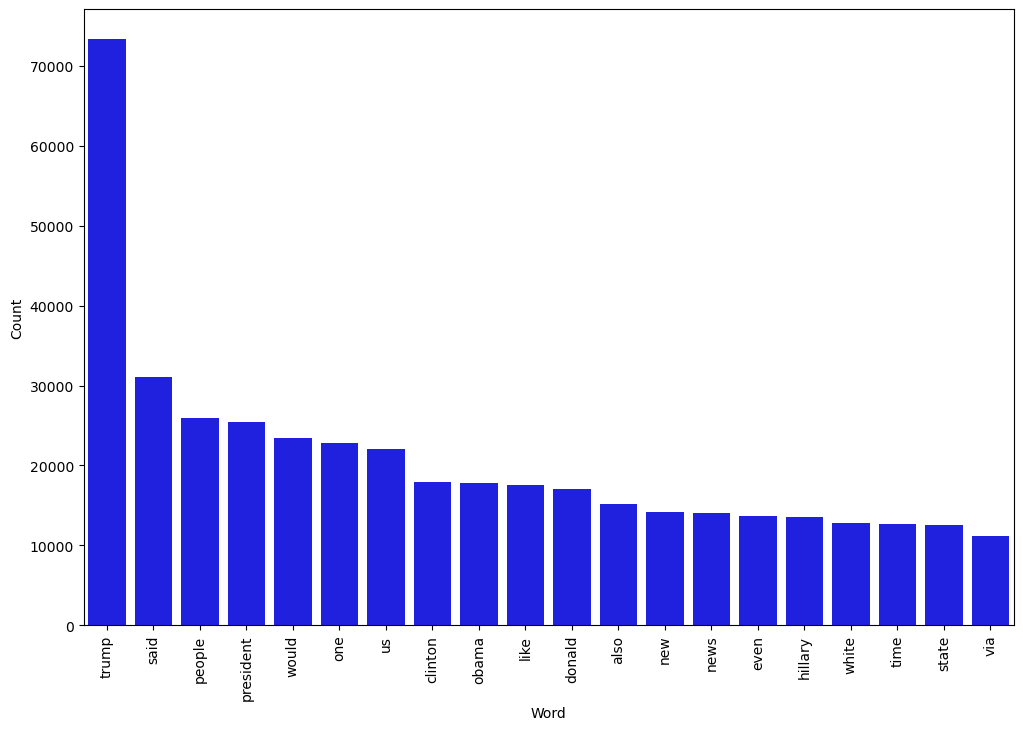

In [24]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

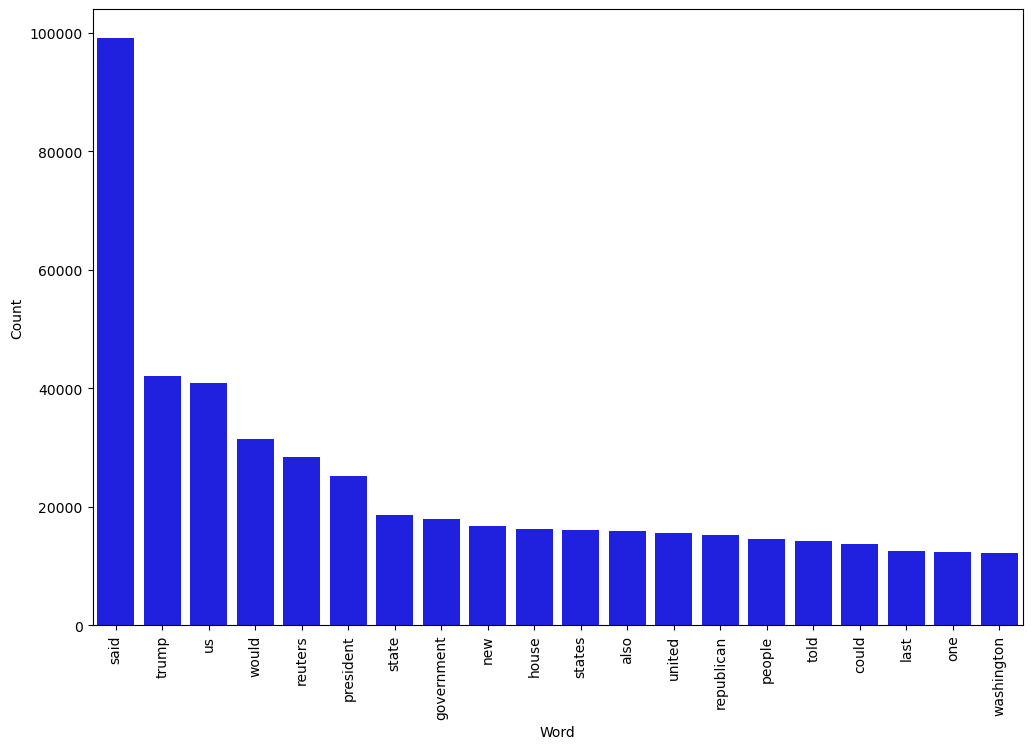

In [25]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

In [26]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

Logistic regression

In [28]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.65%


Confusion matrix, without normalization


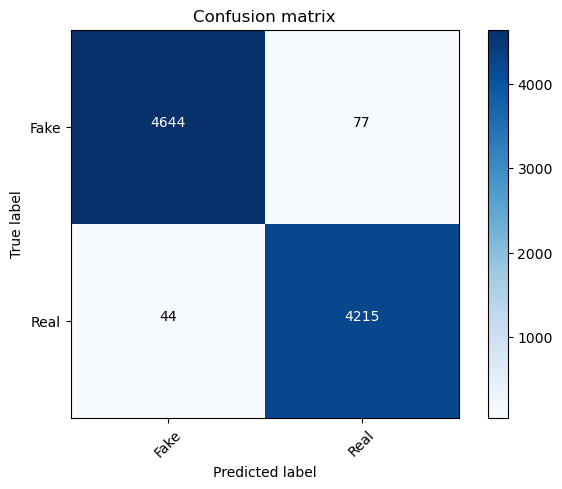

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.61%


Confusion matrix, without normalization


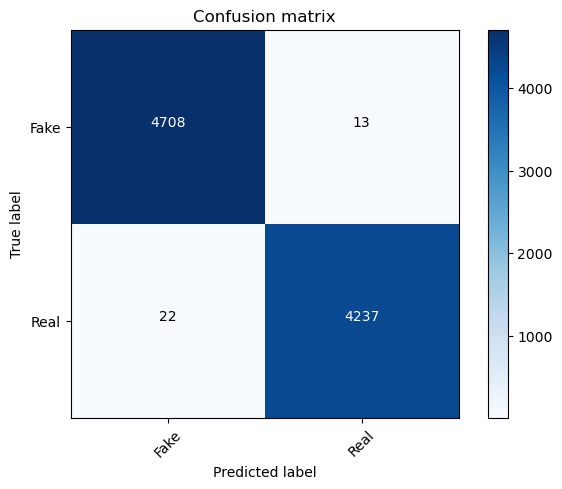

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

Random Forest Classifier

In [32]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.11%


Confusion matrix, without normalization


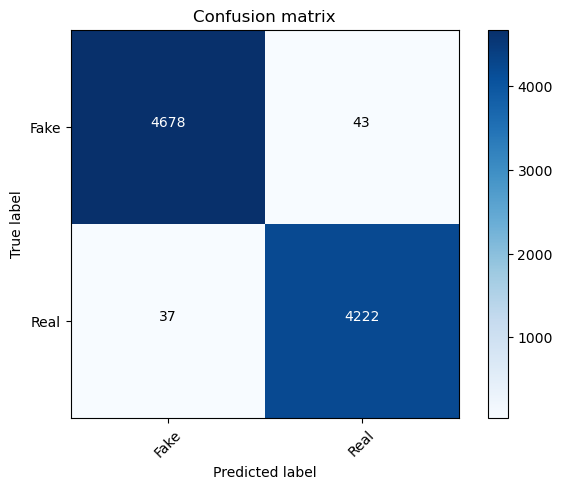

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])